In [1]:
import os
import pickle
import random
import statistics
import time

import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from prompt_classifier.metrics import evaluate
from prompt_classifier.modeling.dspy_llm import LlmClassifier
from prompt_classifier.modeling.fasttext import FastTextClassifier
from prompt_classifier.modeling.nli_modernbert import ModernBERTNLI
from prompt_classifier.util import create_domain_dataset, train_and_evaluate_model

load_dotenv()
random.seed(1)

In [2]:
providers = ort.get_available_providers()

print(providers)

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [3]:
law_prompts = pd.read_csv("data/processed/law_prompts.csv")
healthcare_prompts = pd.read_csv("data/processed/healthcare_prompts.csv")
finance_prompts = pd.read_csv("data/processed/finance_prompts.csv")

law_dataset = create_domain_dataset(
    law_prompts,
    [healthcare_prompts, finance_prompts]
)

healthcare_dataset = create_domain_dataset(
    healthcare_prompts,
    [law_prompts, finance_prompts]
)

finance_dataset = create_domain_dataset(
    finance_prompts,
    [law_prompts, healthcare_prompts]
)

datasets = {
    "law": law_dataset,
    "healthcare": healthcare_dataset,
    "finance": finance_dataset,
}

In [4]:
law_prompts_interim = pd.read_csv("data/interim/law_prompts.csv")
healthcare_prompts_interim = pd.read_csv("data/interim/healthcare_prompts.csv")
finance_prompts_interim = pd.read_csv("data/interim/finance_prompts.csv")

law_dataset_interim = create_domain_dataset(
    law_prompts_interim,
    [healthcare_prompts_interim, finance_prompts_interim]
)

healthcare_dataset_interim = create_domain_dataset(
    healthcare_prompts_interim,
    [law_prompts_interim, finance_prompts_interim]
)

finance_dataset_interim = create_domain_dataset(
    finance_prompts_interim,
    [law_prompts_interim, healthcare_prompts_interim]
)

datasets_interim = {
    "law": law_dataset_interim,
    "healthcare": healthcare_dataset_interim,
    "finance": finance_dataset_interim,
}

In [5]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5",
    providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer()

2025-03-28 14:58:05.917617641 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-03-28 14:58:05.917653330 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-03-28 14:58:06.376905472 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-03-28 14:58:06.376944966 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [6]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch._dynamo.config.suppress_errors = True # Suppresses warnings in ModernBERT

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Using device: cuda


# GPT and ModernBERT loop using interim data

Going to sample between 1 and 8 traces per predictor.
Will attempt to bootstrap 4 candidate sets.
Average Metric: 628.00 / 800 (78.5%): 100%|██████████| 800/800 [02:26<00:00,  5.48it/s]

2025/03/28 15:00:32 INFO dspy.evaluate.evaluate: Average Metric: 628 / 800 (78.5%)



New best score: 78.5 for seed -3
Scores so far: [78.5]
Best score so far: 78.5
Average Metric: 548.00 / 800 (68.5%): 100%|██████████| 800/800 [07:10<00:00,  1.86it/s]

2025/03/28 15:07:43 INFO dspy.evaluate.evaluate: Average Metric: 548 / 800 (68.5%)



Scores so far: [78.5, 68.5]
Best score so far: 78.5


  2%|▏         | 12/800 [00:00<00:02, 283.42it/s]


Bootstrapped 8 full traces after 12 examples for up to 1 rounds, amounting to 12 attempts.
Average Metric: 606.00 / 800 (75.8%): 100%|██████████| 800/800 [07:59<00:00,  1.67it/s]

2025/03/28 15:15:43 INFO dspy.evaluate.evaluate: Average Metric: 606 / 800 (75.8%)



Scores so far: [78.5, 68.5, 75.75]
Best score so far: 78.5


  1%|          | 8/800 [00:03<05:51,  2.25it/s]


Bootstrapped 7 full traces after 8 examples for up to 1 rounds, amounting to 8 attempts.
Average Metric: 681.00 / 800 (85.1%): 100%|██████████| 800/800 [04:34<00:00,  2.91it/s]

2025/03/28 15:20:21 INFO dspy.evaluate.evaluate: Average Metric: 681 / 800 (85.1%)



New best score: 85.12 for seed 0
Scores so far: [78.5, 68.5, 75.75, 85.12]
Best score so far: 85.12


  0%|          | 3/800 [00:02<09:21,  1.42it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 597.00 / 800 (74.6%): 100%|██████████| 800/800 [03:23<00:00,  3.93it/s]

2025/03/28 15:23:47 INFO dspy.evaluate.evaluate: Average Metric: 597 / 800 (74.6%)



Scores so far: [78.5, 68.5, 75.75, 85.12, 74.62]
Best score so far: 85.12


  0%|          | 2/800 [00:01<12:19,  1.08it/s]


Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 620.00 / 800 (77.5%): 100%|██████████| 800/800 [02:49<00:00,  4.72it/s]

2025/03/28 15:26:38 INFO dspy.evaluate.evaluate: Average Metric: 620 / 800 (77.5%)



Scores so far: [78.5, 68.5, 75.75, 85.12, 74.62, 77.5]
Best score so far: 85.12


  1%|          | 7/800 [00:06<11:41,  1.13it/s]


Bootstrapped 4 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Average Metric: 551.00 / 800 (68.9%): 100%|██████████| 800/800 [11:20<00:00,  1.18it/s]

2025/03/28 15:38:05 INFO dspy.evaluate.evaluate: Average Metric: 551 / 800 (68.9%)



Scores so far: [78.5, 68.5, 75.75, 85.12, 74.62, 77.5, 68.88]
Best score so far: 85.12
7 candidate programs found.


  2%|▏         | 78/4000 [00:48<36:51,  1.77it/s]  

Unexpected non-binary label found: 


  6%|▌         | 231/4000 [02:14<35:38,  1.76it/s]  

Unexpected non-binary label found: N/A


  7%|▋         | 274/4000 [02:37<1:40:05,  1.61s/it]

Unexpected non-binary label found: (Insert summary here)


 16%|█▌        | 620/4000 [05:27<46:05,  1.22it/s]  

Unexpected non-binary label found: (Insert output label here)


 16%|█▌        | 645/4000 [05:40<33:45,  1.66it/s]

Unexpected non-binary label found: 


 17%|█▋        | 671/4000 [05:58<1:08:25,  1.23s/it]

Unexpected non-binary label found: None


 18%|█▊        | 715/4000 [06:18<30:54,  1.77it/s]  

Unexpected non-binary label found: (Insert label here)


 19%|█▉        | 750/4000 [06:39<42:23,  1.28it/s]  

Unexpected non-binary label found: {label}


 24%|██▍       | 961/4000 [08:19<30:54,  1.64it/s]  

Unexpected non-binary label found: N/A


 28%|██▊       | 1112/4000 [09:30<40:20,  1.19it/s]  

Unexpected non-binary label found: None


 30%|██▉       | 1190/4000 [10:09<15:07,  3.10it/s]  

Unexpected non-binary label found: had been dancing


 34%|███▍      | 1364/4000 [11:31<1:04:58,  1.48s/it]

Unexpected non-binary label found: [Type of clause]


 34%|███▍      | 1365/4000 [11:31<49:34,  1.13s/it]  

Unexpected non-binary label found: N/A


 39%|███▉      | 1562/4000 [13:01<26:15,  1.55it/s]  

Unexpected non-binary label found: The term "Web Development" refers to the process of designing, building, maintaining, and updating websites, web applications, and other online platforms. It involves a range of activities, including coding, database management, user experience (UX) design, and project management, with the goal of creating functional and visually appealing digital products that meet the needs of users.


 40%|████      | 1602/4000 [13:20<30:58,  1.29it/s]

Unexpected non-binary label found: (Insert review here)


 42%|████▏     | 1684/4000 [14:02<21:27,  1.80it/s]

Unexpected non-binary label found: None


 42%|████▏     | 1687/4000 [14:04<23:06,  1.67it/s]

Unexpected non-binary label found: (Insert label here)


 47%|████▋     | 1889/4000 [15:39<23:57,  1.47it/s]  

Unexpected non-binary label found: (Waiting for output)


 49%|████▉     | 1960/4000 [16:17<27:11,  1.25it/s]

Unexpected non-binary label found: N/A


 49%|████▉     | 1979/4000 [16:26<19:13,  1.75it/s]

Unexpected non-binary label found: [waiting for input]


 51%|█████     | 2022/4000 [16:48<22:23,  1.47it/s]

Unexpected non-binary label found: (Insert label here)


 52%|█████▏    | 2071/4000 [17:16<24:05,  1.33it/s]

Unexpected non-binary label found: Unknown


 52%|█████▏    | 2075/4000 [17:18<25:26,  1.26it/s]

Unexpected non-binary label found: N/A


 52%|█████▏    | 2093/4000 [17:27<24:15,  1.31it/s]

Unexpected non-binary label found: (Insert label here)


 53%|█████▎    | 2129/4000 [17:47<21:37,  1.44it/s]

Unexpected non-binary label found: N/A


 54%|█████▎    | 2144/4000 [17:53<18:36,  1.66it/s]

Unexpected non-binary label found: Waiting for text to relate...


 56%|█████▌    | 2239/4000 [18:49<11:19,  2.59it/s]

Unexpected non-binary label found: neutral


 57%|█████▋    | 2264/4000 [19:06<24:28,  1.18it/s]

Unexpected non-binary label found: N/A


 58%|█████▊    | 2301/4000 [19:31<16:29,  1.72it/s]  

Unexpected non-binary label found: [No Label]


 58%|█████▊    | 2336/4000 [19:53<18:57,  1.46it/s]

Unexpected non-binary label found: None


 60%|█████▉    | 2395/4000 [20:33<21:25,  1.25it/s]

Unexpected non-binary label found: 


 61%|██████    | 2421/4000 [20:46<17:52,  1.47it/s]

Unexpected non-binary label found: ?


 61%|██████    | 2436/4000 [20:52<11:13,  2.32it/s]

Unexpected non-binary label found: ?


 64%|██████▍   | 2578/4000 [22:29<22:42,  1.04it/s]

Unexpected non-binary label found: ?


 66%|██████▌   | 2632/4000 [23:14<14:02,  1.62it/s]  

Unexpected non-binary label found: 


 66%|██████▌   | 2639/4000 [23:16<11:24,  1.99it/s]

Unexpected non-binary label found: 


 68%|██████▊   | 2715/4000 [24:17<2:18:28,  6.47s/it]

Unexpected non-binary label found: [[##label##]]



[[##label##]]

[[##label##]]



[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##label##]]





[[##

 70%|██████▉   | 2795/4000 [25:00<10:28,  1.92it/s]  

Unexpected non-binary label found: [Unknown]


 72%|███████▏  | 2860/4000 [25:37<13:03,  1.45it/s]

Unexpected non-binary label found: [Insert label here]


 72%|███████▏  | 2881/4000 [25:50<20:36,  1.11s/it]

Unexpected non-binary label found: N/A


 74%|███████▍  | 2972/4000 [26:40<09:41,  1.77it/s]

Unexpected non-binary label found: N/A


 75%|███████▍  | 2996/4000 [26:49<09:25,  1.77it/s]

Unexpected non-binary label found: ?


 81%|████████  | 3224/4000 [29:20<07:46,  1.66it/s]

Unexpected non-binary label found: ?


 83%|████████▎ | 3325/4000 [30:13<07:46,  1.45it/s]

Unexpected non-binary label found: Waiting for input...


 83%|████████▎ | 3328/4000 [30:15<09:00,  1.24it/s]

Unexpected non-binary label found: Neither


 86%|████████▌ | 3430/4000 [31:15<06:27,  1.47it/s]

Unexpected non-binary label found: (Insert summary sentence here)


 86%|████████▋ | 3450/4000 [31:26<04:40,  1.96it/s]

Unexpected non-binary label found: (Insert label here)


 87%|████████▋ | 3498/4000 [31:54<06:33,  1.28it/s]

Unexpected non-binary label found: [Unknown]


 89%|████████▉ | 3578/4000 [32:46<05:53,  1.19it/s]

Unexpected non-binary label found: None


 91%|█████████ | 3622/4000 [33:15<02:19,  2.71it/s]

Unexpected non-binary label found: undefined


 92%|█████████▏| 3660/4000 [33:31<03:06,  1.82it/s]

Unexpected non-binary label found: None


 92%|█████████▏| 3695/4000 [33:53<02:53,  1.76it/s]

Unexpected non-binary label found: N/A


 96%|█████████▋| 3859/4000 [35:33<01:27,  1.60it/s]

Unexpected non-binary label found: ?


100%|██████████| 4000/4000 [36:53<00:00,  1.81it/s]


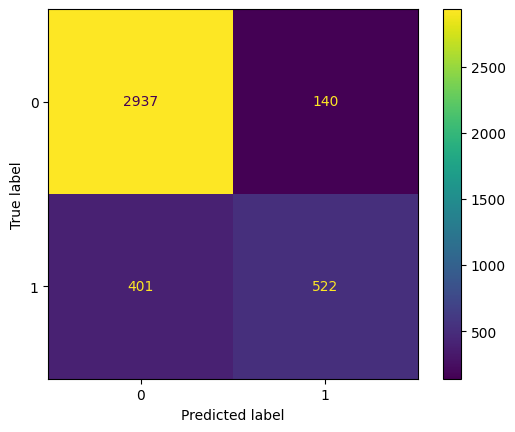

config.json:   0%|          | 0.00/5.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


tokenizer_config.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Device set to use cuda:0
  0%|          | 0/30000 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 30000/30000 [13:25<00:00, 37.23it/s]  


[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

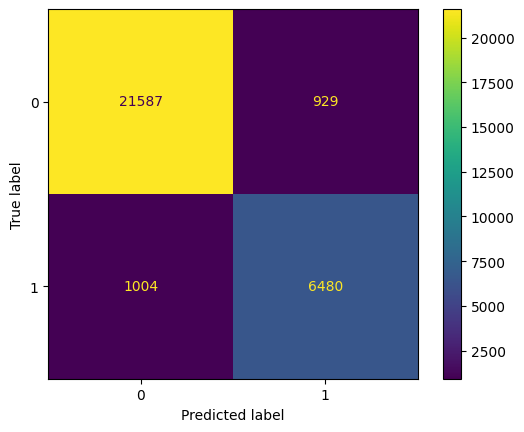

Going to sample between 1 and 8 traces per predictor.
Will attempt to bootstrap 4 candidate sets.
Average Metric: 657.00 / 800 (82.1%): 100%|██████████| 800/800 [02:18<00:00,  5.76it/s]

2025/03/28 16:31:03 INFO dspy.evaluate.evaluate: Average Metric: 657 / 800 (82.1%)



New best score: 82.12 for seed -3
Scores so far: [82.12]
Best score so far: 82.12
Average Metric: 599.00 / 800 (74.9%): 100%|██████████| 800/800 [02:11<00:00,  6.07it/s]

2025/03/28 16:33:15 INFO dspy.evaluate.evaluate: Average Metric: 599 / 800 (74.9%)



Scores so far: [82.12, 74.88]
Best score so far: 82.12


  2%|▏         | 12/800 [00:00<00:02, 343.44it/s]


Bootstrapped 8 full traces after 12 examples for up to 1 rounds, amounting to 12 attempts.
Average Metric: 569.00 / 800 (71.1%): 100%|██████████| 800/800 [07:03<00:00,  1.89it/s]

2025/03/28 16:40:19 INFO dspy.evaluate.evaluate: Average Metric: 569 / 800 (71.1%)



Scores so far: [82.12, 74.88, 71.12]
Best score so far: 82.12


  1%|▏         | 10/800 [00:05<07:17,  1.81it/s]


Bootstrapped 7 full traces after 10 examples for up to 1 rounds, amounting to 10 attempts.
Average Metric: 720.00 / 800 (90.0%): 100%|██████████| 800/800 [02:35<00:00,  5.14it/s]

2025/03/28 16:43:00 INFO dspy.evaluate.evaluate: Average Metric: 720 / 800 (90.0%)



New best score: 90.0 for seed 0
Scores so far: [82.12, 74.88, 71.12, 90.0]
Best score so far: 90.0


  0%|          | 3/800 [00:01<08:17,  1.60it/s]


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 615.00 / 800 (76.9%): 100%|██████████| 800/800 [02:44<00:00,  4.88it/s]

2025/03/28 16:45:46 INFO dspy.evaluate.evaluate: Average Metric: 615 / 800 (76.9%)



Scores so far: [82.12, 74.88, 71.12, 90.0, 76.88]
Best score so far: 90.0


  0%|          | 1/800 [00:01<18:47,  1.41s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 574.00 / 800 (71.8%): 100%|██████████| 800/800 [04:22<00:00,  3.05it/s]


2025/03/28 16:50:10 INFO dspy.evaluate.evaluate: Average Metric: 574 / 800 (71.8%)


Scores so far: [82.12, 74.88, 71.12, 90.0, 76.88, 71.75]
Best score so far: 90.0


  0%|          | 4/800 [00:02<07:26,  1.78it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 687.00 / 800 (85.9%): 100%|██████████| 800/800 [03:10<00:00,  4.20it/s]

2025/03/28 16:53:23 INFO dspy.evaluate.evaluate: Average Metric: 687 / 800 (85.9%)



Scores so far: [82.12, 74.88, 71.12, 90.0, 76.88, 71.75, 85.88]
Best score so far: 90.0
7 candidate programs found.


  3%|▎         | 113/4000 [00:44<32:08,  2.02it/s] 

Unexpected non-binary label found: 


 14%|█▍        | 557/4000 [03:29<20:14,  2.84it/s]  

Unexpected non-binary label found: informal


 24%|██▎       | 942/4000 [05:47<16:33,  3.08it/s]  

Unexpected non-binary label found: 5


 26%|██▌       | 1032/4000 [06:18<15:39,  3.16it/s]

Unexpected non-binary label found: N/A


 31%|███▏      | 1259/4000 [07:40<21:22,  2.14it/s]  

Unexpected non-binary label found: N/A


 36%|███▌      | 1434/4000 [08:44<16:15,  2.63it/s]  

Unexpected non-binary label found: (Insert label here)


 42%|████▏     | 1696/4000 [10:18<21:05,  1.82it/s]

Unexpected non-binary label found: N/A


 47%|████▋     | 1889/4000 [11:29<19:11,  1.83it/s]

Unexpected non-binary label found: N/A


 59%|█████▉    | 2361/4000 [14:23<14:22,  1.90it/s]

Unexpected non-binary label found: (Insert label here)


 93%|█████████▎| 3704/4000 [22:35<02:37,  1.88it/s]

Unexpected non-binary label found: None


100%|██████████| 4000/4000 [24:26<00:00,  2.73it/s]


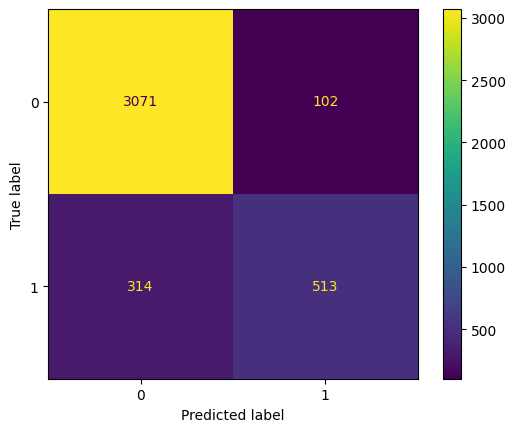

Device set to use cuda:0
100%|██████████| 30000/30000 [12:35<00:00, 39.73it/s]  


[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 

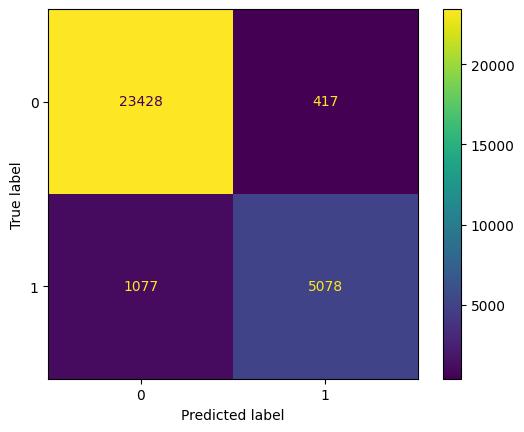

Going to sample between 1 and 8 traces per predictor.
Will attempt to bootstrap 4 candidate sets.
Average Metric: 386.00 / 800 (48.2%): 100%|██████████| 800/800 [02:12<00:00,  6.05it/s]

2025/03/28 17:32:38 INFO dspy.evaluate.evaluate: Average Metric: 386 / 800 (48.2%)



New best score: 48.25 for seed -3
Scores so far: [48.25]
Best score so far: 48.25
Average Metric: 513.00 / 800 (64.1%): 100%|██████████| 800/800 [05:20<00:00,  2.50it/s]


2025/03/28 17:37:59 INFO dspy.evaluate.evaluate: Average Metric: 513 / 800 (64.1%)


New best score: 64.12 for seed -2
Scores so far: [48.25, 64.12]
Best score so far: 64.12


  1%|▏         | 11/800 [00:00<00:02, 329.56it/s]

Bootstrapped 8 full traces after 11 examples for up to 1 rounds, amounting to 11 attempts.


Average Metric: 535.00 / 800 (66.9%): 100%|██████████| 800/800 [06:54<00:00,  1.93it/s]

2025/03/28 17:44:53 INFO dspy.evaluate.evaluate: Average Metric: 535 / 800 (66.9%)



New best score: 66.88 for seed -1
Scores so far: [48.25, 64.12, 66.88]
Best score so far: 66.88


  1%|          | 8/800 [00:02<04:46,  2.76it/s]


Bootstrapped 7 full traces after 8 examples for up to 1 rounds, amounting to 8 attempts.
Average Metric: 682.00 / 800 (85.2%): 100%|██████████| 800/800 [02:45<00:00,  4.83it/s]

2025/03/28 17:47:42 INFO dspy.evaluate.evaluate: Average Metric: 682 / 800 (85.2%)



New best score: 85.25 for seed 0
Scores so far: [48.25, 64.12, 66.88, 85.25]
Best score so far: 85.25


  1%|          | 7/800 [00:04<07:49,  1.69it/s]


Bootstrapped 3 full traces after 7 examples for up to 1 rounds, amounting to 7 attempts.
Average Metric: 709.00 / 800 (88.6%): 100%|██████████| 800/800 [02:36<00:00,  5.13it/s]

2025/03/28 17:50:22 INFO dspy.evaluate.evaluate: Average Metric: 709 / 800 (88.6%)



New best score: 88.62 for seed 1
Scores so far: [48.25, 64.12, 66.88, 85.25, 88.62]
Best score so far: 88.62


  0%|          | 1/800 [00:01<15:58,  1.20s/it]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 419.00 / 800 (52.4%): 100%|██████████| 800/800 [05:30<00:00,  2.42it/s]

2025/03/28 17:55:54 INFO dspy.evaluate.evaluate: Average Metric: 419 / 800 (52.4%)



Scores so far: [48.25, 64.12, 66.88, 85.25, 88.62, 52.38]
Best score so far: 88.62


  0%|          | 4/800 [00:02<07:16,  1.82it/s]


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 641.00 / 800 (80.1%): 100%|██████████| 800/800 [02:44<00:00,  4.85it/s]

2025/03/28 17:58:41 INFO dspy.evaluate.evaluate: Average Metric: 641 / 800 (80.1%)



Scores so far: [48.25, 64.12, 66.88, 85.25, 88.62, 52.38, 80.12]
Best score so far: 88.62
7 candidate programs found.


  1%|▏         | 51/4000 [00:23<1:34:13,  1.43s/it]

Unexpected non-binary label found: N/A


  2%|▏         | 60/4000 [00:27<31:09,  2.11it/s]  

Unexpected non-binary label found: ?


  5%|▍         | 182/4000 [01:13<25:34,  2.49it/s]  

Unexpected non-binary label found: [##]


  6%|▌         | 231/4000 [01:34<19:15,  3.26it/s]  

Unexpected non-binary label found: None


  9%|▉         | 360/4000 [02:21<21:35,  2.81it/s]  

Unexpected non-binary label found: N/A


  9%|▉         | 378/4000 [02:28<27:02,  2.23it/s]

Unexpected non-binary label found: bad


 10%|▉         | 388/4000 [02:35<1:00:56,  1.01s/it]

Unexpected non-binary label found: N/A


 10%|█         | 414/4000 [02:46<33:24,  1.79it/s]  

Unexpected non-binary label found: N/A


 12%|█▏        | 461/4000 [03:08<1:37:24,  1.65s/it]

Unexpected non-binary label found: N/A


 15%|█▌        | 611/4000 [04:02<33:11,  1.70it/s]  

Unexpected non-binary label found: N/A


 16%|█▌        | 628/4000 [04:08<23:01,  2.44it/s]

Unexpected non-binary label found: This request is out of scope as it requires a nutritional analysis which cannot be done without specific ingredients. Please provide the ingredients.


 16%|█▋        | 655/4000 [04:21<16:32,  3.37it/s]  

Unexpected non-binary label found: N/A


 17%|█▋        | 679/4000 [04:33<1:10:22,  1.27s/it]

Unexpected non-binary label found: N/A


 19%|█▉        | 758/4000 [05:02<21:35,  2.50it/s]  

Unexpected non-binary label found: Mysterious, Ambitious, Charismatic, Intelligent, Resourceful, Determined, Independent, Enigmatic


 19%|█▉        | 774/4000 [05:07<16:59,  3.16it/s]

Unexpected non-binary label found: 6


 20%|█▉        | 796/4000 [05:15<17:08,  3.12it/s]

Unexpected non-binary label found: N/A


 20%|██        | 806/4000 [05:22<44:31,  1.20it/s]  

Unexpected non-binary label found: 2x + 6


 21%|██        | 838/4000 [05:33<22:01,  2.39it/s]

Unexpected non-binary label found: This field is missing. Please provide the input to explain its importance.


 22%|██▏       | 898/4000 [05:58<35:53,  1.44it/s]  

Unexpected non-binary label found: N/A


 23%|██▎       | 908/4000 [06:01<16:12,  3.18it/s]

Unexpected non-binary label found: None


 23%|██▎       | 915/4000 [06:05<32:50,  1.57it/s]

Unexpected non-binary label found: The process of designing, building, and maintaining websites, applications, and other online platforms using various programming languages, tools, and technologies.


 24%|██▎       | 944/4000 [06:19<36:19,  1.40it/s]  

Unexpected non-binary label found: 5


 26%|██▋       | 1058/4000 [07:03<24:14,  2.02it/s]  

Unexpected non-binary label found: N/A


 30%|███       | 1210/4000 [08:09<55:44,  1.20s/it]  

Unexpected non-binary label found: N/A


 31%|███▏      | 1252/4000 [08:23<21:03,  2.17it/s]

Unexpected non-binary label found: [## unknown ##]]


 33%|███▎      | 1305/4000 [08:46<44:03,  1.02it/s]  

Unexpected non-binary label found: N/A


 36%|███▌      | 1448/4000 [09:40<18:46,  2.27it/s]  

Unexpected non-binary label found: This is not possible as there is no text provided. Please provide the text you would like me to analyze, and I will be happy to assist.


 38%|███▊      | 1507/4000 [10:03<11:35,  3.58it/s]

Unexpected non-binary label found: N/A


 40%|███▉      | 1587/4000 [10:33<12:52,  3.12it/s]

Unexpected non-binary label found: B


 41%|████      | 1633/4000 [10:50<19:25,  2.03it/s]

Unexpected non-binary label found: ]]


 42%|████▏     | 1660/4000 [11:04<25:41,  1.52it/s]

Unexpected non-binary label found: N/A


 42%|████▏     | 1697/4000 [11:18<13:10,  2.91it/s]

Unexpected non-binary label found: N/A


 43%|████▎     | 1735/4000 [11:37<11:57,  3.16it/s]  

Unexpected non-binary label found: 32


 44%|████▍     | 1779/4000 [11:56<37:14,  1.01s/it]

Unexpected non-binary label found: N/A


 45%|████▍     | 1782/4000 [11:58<27:07,  1.36it/s]

Unexpected non-binary label found: N/A


 48%|████▊     | 1909/4000 [12:49<10:51,  3.21it/s]

Unexpected non-binary label found: C


 51%|█████     | 2035/4000 [13:43<41:01,  1.25s/it]

Unexpected non-binary label found: N/A


 51%|█████     | 2039/4000 [13:44<17:36,  1.86it/s]

Unexpected non-binary label found: N/A


 51%|█████     | 2045/4000 [13:46<10:28,  3.11it/s]

Unexpected non-binary label found: None


 54%|█████▎    | 2148/4000 [14:25<09:40,  3.19it/s]

Unexpected non-binary label found: N/A


 55%|█████▌    | 2209/4000 [14:51<17:21,  1.72it/s]

Unexpected non-binary label found: (Insert output here)


 56%|█████▌    | 2238/4000 [15:02<12:56,  2.27it/s]

Unexpected non-binary label found: N/A


 58%|█████▊    | 2328/4000 [15:39<11:38,  2.39it/s]

Unexpected non-binary label found: N/A


 58%|█████▊    | 2337/4000 [15:42<09:04,  3.06it/s]

Unexpected non-binary label found: N/A


 59%|█████▉    | 2370/4000 [15:56<12:33,  2.16it/s]

Unexpected non-binary label found: None


 60%|█████▉    | 2385/4000 [16:03<22:29,  1.20it/s]

Unexpected non-binary label found: N/A


 62%|██████▏   | 2477/4000 [16:41<12:26,  2.04it/s]

Unexpected non-binary label found: None of the above


 63%|██████▎   | 2514/4000 [16:55<12:57,  1.91it/s]

Unexpected non-binary label found: ...label...


 68%|██████▊   | 2730/4000 [18:14<07:57,  2.66it/s]

Unexpected non-binary label found: CCO - Common Complex Occurrences


 72%|███████▎  | 2900/4000 [19:20<08:52,  2.07it/s]

Unexpected non-binary label found: N/A


 76%|███████▌  | 3048/4000 [20:17<11:57,  1.33it/s]

Unexpected non-binary label found: N/A


 78%|███████▊  | 3110/4000 [20:44<04:40,  3.18it/s]

Unexpected non-binary label found: None


 78%|███████▊  | 3139/4000 [20:58<05:37,  2.55it/s]

Unexpected non-binary label found: N/A


 79%|███████▉  | 3171/4000 [21:08<04:09,  3.32it/s]

Unexpected non-binary label found: N/A


 79%|███████▉  | 3177/4000 [21:09<04:27,  3.07it/s]

Unexpected non-binary label found: Not enough information provided to select a label. Please provide more context or specify which words are in the list.


 80%|███████▉  | 3189/4000 [21:17<14:17,  1.06s/it]

Unexpected non-binary label found: N/A


 80%|████████  | 3207/4000 [21:24<08:07,  1.63it/s]

Unexpected non-binary label found: N/A


 81%|████████  | 3241/4000 [21:40<05:44,  2.21it/s]

Unexpected non-binary label found: (2x + 3y) - (3x + 3y)
= 2x + 3y - 3x - 3y
= 2x - 3x
= -x


 84%|████████▍ | 3371/4000 [22:27<03:43,  2.82it/s]

Unexpected non-binary label found: None of the above


 87%|████████▋ | 3475/4000 [23:09<09:51,  1.13s/it]

Unexpected non-binary label found: N/A


 88%|████████▊ | 3500/4000 [23:25<11:14,  1.35s/it]

Unexpected non-binary label found: N/A


 90%|████████▉ | 3588/4000 [23:58<02:11,  3.13it/s]

Unexpected non-binary label found: N/A


 91%|█████████ | 3638/4000 [24:19<06:25,  1.07s/it]

Unexpected non-binary label found: N/A


 91%|█████████ | 3642/4000 [24:19<02:33,  2.33it/s]

Unexpected non-binary label found: N/A


 92%|█████████▏| 3664/4000 [24:30<03:31,  1.59it/s]

Unexpected non-binary label found: N/A


 93%|█████████▎| 3719/4000 [24:56<02:06,  2.22it/s]

Unexpected non-binary label found: N/A


 98%|█████████▊| 3912/4000 [26:16<00:31,  2.84it/s]

Unexpected non-binary label found: ?


 99%|█████████▉| 3978/4000 [26:49<00:15,  1.38it/s]

Unexpected non-binary label found: N/A


100%|██████████| 4000/4000 [26:56<00:00,  2.48it/s]


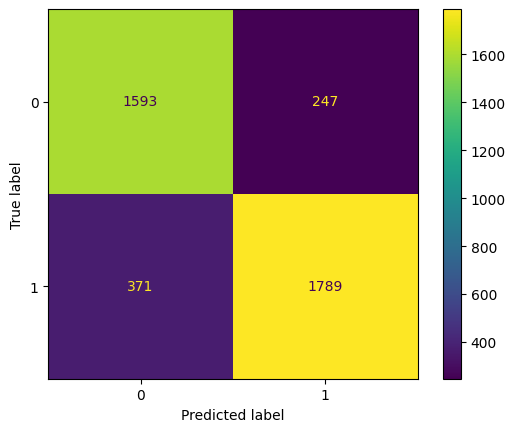

Device set to use cuda:0
100%|██████████| 30000/30000 [12:34<00:00, 39.74it/s]  


[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 

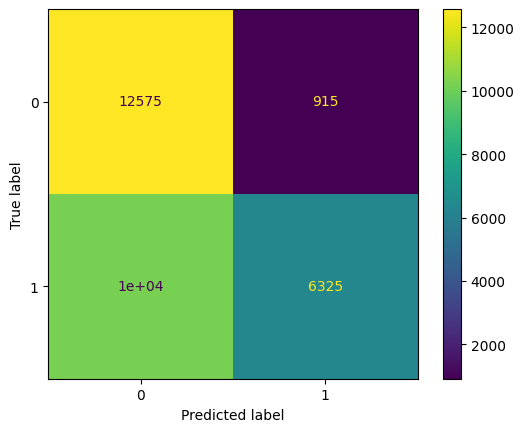

In [7]:
for domain, dataset in datasets_interim.items():
    # Split data
    train_data = dataset.sample(n=800)
    test_data = dataset.drop(train_data.index).sample(n=4000)

    # GPT Classifier
    """
    llm_classifier = LlmClassifier(
        api_key=os.getenv("OPENAI_API_KEY"),
        api_base=os.getenv("PROXY_URL"),
        model_name="gpt-4o-mini",
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )
    """
    llm_classifier = LlmClassifier(
        api_key='',
        api_base='http://localhost:11434',
        model_name='ollama_chat/llama3.2:3b',
        domain=domain,
        train_data=train_data,
        test_data=test_data,
    )
    try:
        # DSPy optimization
        llm_classifier.optimize_model()

        # Get predictions and metrics for test data
        test_predictions, test_actuals, test_latency = llm_classifier.predict()
        test_latency = statistics.mean(test_latency)

        test_acc = metrics.accuracy_score(test_actuals, test_predictions)

        # Evaluate and save model
        evaluate(
            predictions=test_predictions,
            true_labels=test_actuals,
            domain=domain,
            model_name="gpt4o-mini",
            embed_model="ada-002",
            cost=llm_classifier.cost,
            latency=test_latency,
            train_acc=test_acc
        )

        llm_classifier.save_model(f"models/gpt-4o-mini-{domain}.json")

    except Exception as e:
        print(f"Error running GPT model: {e}")


    try:
        test_data = dataset.sample(n=30_000)
        # ModernBERT Classifier
        bert_classifier = ModernBERTNLI(domain=domain)
        bert_classifier.classifier.model.to("cuda")

        # Test predictions
        test_predictions = []
        test_times = []
        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            start_time = time.perf_counter_ns()
            pred = bert_classifier.predict(row["prompt"])
            test_predictions.append(pred)
            test_times.append(time.perf_counter_ns() - start_time)

        print(test_predictions)
        test_acc = metrics.accuracy_score(test_data["label"], test_predictions)
        mean_prediction_time = statistics.mean(test_times)

        # Evaluate ModernBERT
        evaluate(
            predictions=test_predictions,
            true_labels=test_data["label"],
            domain=domain,
            model_name="modernbert",
            embed_model="bert-base",
            latency=mean_prediction_time,
            train_acc=test_acc
        )
    except Exception as e:
        print(f"Error running ModernBERT model: {e}")

# SVM, fastText and XGBoost loop using processed data

In [8]:
embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

In [ ]:
print(f"BAAI-BGE available providers: {baai_embedding.model.model.get_providers()}")
print(f"MiniLM available providers: {mini_embedding.model.model.get_providers()}")

BAAI-BGE available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
MiniLM available providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']


: 

Progress: 100.0% Trials:   23 Best score:  0.994921 ETA:   0h 0m 0s
Training again with best arguments
Read 1M words
Number of words:  78086
Number of labels: 2
Progress: 100.0% words/sec/thread: 1063493 lr:  0.000000 avg.loss:  0.021639 ETA:   0h 0m 0s
100%|██████████| 13500/13500 [00:00<00:00, 15020.20it/s]


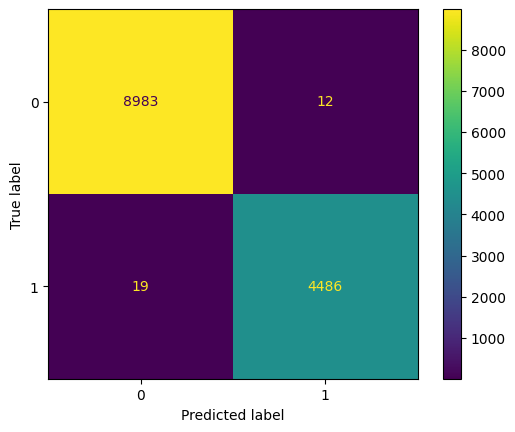

Training mini embeddings on law domain using SVM
Cross-validation accuracy: 0.9942857142857143 ± 0.0034191522584980857


Evaluating SVM on law: 100%|██████████| 13500/13500 [00:06<00:00, 2127.35it/s]


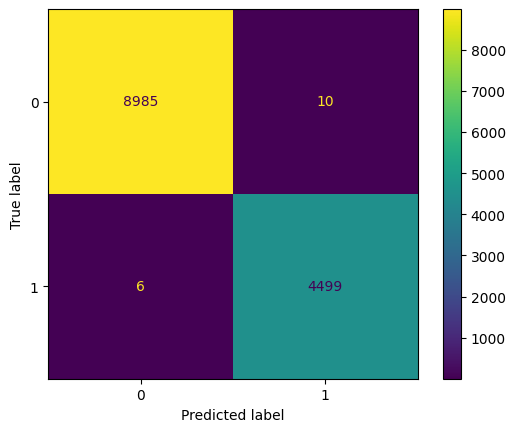

Training mini embeddings on law domain using XGBoost
Cross-validation accuracy: 0.9944444444444445 ± 0.0015873015873015817


Evaluating XGBoost on law: 100%|██████████| 13500/13500 [00:04<00:00, 2837.79it/s]


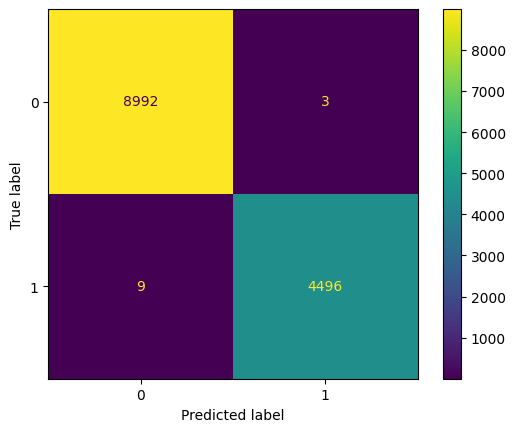

Training tf_idf embeddings on law domain using SVM
Error running SVM model: sparse array length is ambiguous; use getnnz() or shape[0]
Training tf_idf embeddings on law domain using XGBoost
Error running XGBoost model: sparse array length is ambiguous; use getnnz() or shape[0]
Training baai embeddings on law domain using SVM
Cross-validation accuracy: 0.9952380952380953 ± 0.0027947328351839596


Evaluating SVM on law: 100%|██████████| 13500/13500 [00:04<00:00, 2879.89it/s]


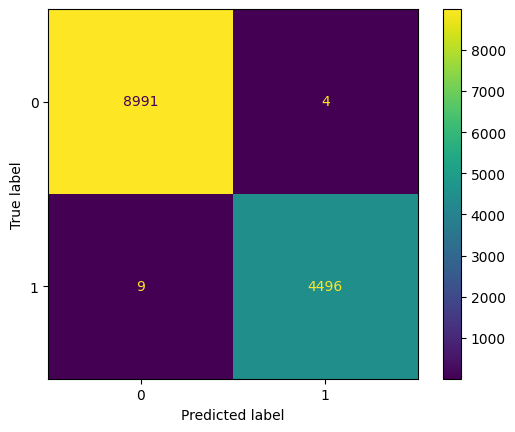

Training baai embeddings on law domain using XGBoost
Cross-validation accuracy: 0.9884126984126984 ± 0.00331438301870175


Evaluating XGBoost on law: 100%|██████████| 13500/13500 [00:04<00:00, 2737.03it/s]


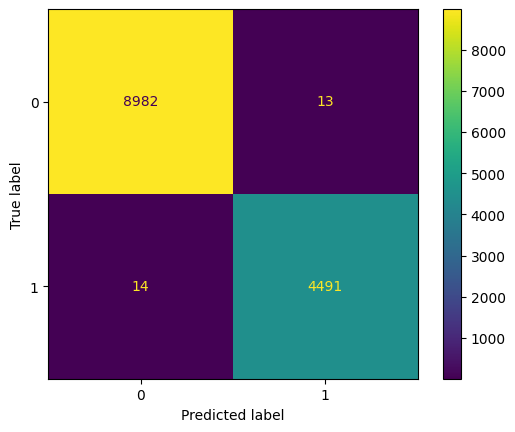

Progress:  52.8% Trials:   11 Best score:  0.996825 ETA:   0h 2m21s

: 

: 

In [10]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.7).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    try:
        fasttext_classifier = FastTextClassifier(train_data=train_data, test_data=test_data)
        fasttext_classifier.train()

        train_predictions = []
        for _, row in train_data.iterrows():
            query = str(row["prompt"]).replace("\n", "")
            prediction = fasttext_classifier.model.predict(query)
            train_predictions.append(1 if prediction[0][0] == "__label__1" else 0)

        train_acc = metrics.accuracy_score(train_data["label"], train_predictions)

        for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
            text = str(row["prompt"])
            query = text.replace("\n", "")

            start_time = time.perf_counter_ns()
            prediction = fasttext_classifier.model.predict(query)
            end_time = time.perf_counter_ns()

            prediction_times.append(end_time - start_time)

            if prediction[0][0] == "__label__1":
                predictions.append(1)
            else:
                predictions.append(0)

            actuals.append(row["label"])

        mean_prediction_time = statistics.mean(prediction_times)

        evaluate(
            predictions,
            true_labels=actuals,
            domain=domain,
            model_name="fastText",
            embed_model="fastText",
            latency=mean_prediction_time,
            train_acc=train_acc,
        )

        fasttext_classifier.model.save_model(f"models/fastText_{domain}_fasttext.bin")
    except Exception as e:
        print(f"Error running fastText model: {e}")

    for model_name, embedding_model in embedding_models.items():
        embed_times: float = None

        # Add timing for embedding creation
        if model_name == "tf_idf":
            embedding_model.fit(train_data["prompt"])

            with open(f"models/tfidf_{domain}.pkl", "wb") as f:
                pickle.dump(embedding_model, f)

            # Time the transform process for training data
            start_time = time.perf_counter_ns()
            train_embeds = embedding_model.transform(train_data["prompt"])
            test_embeds = embedding_model.transform(test_data["prompt"])
            end_time = time.perf_counter_ns()
            embed_times = end_time - start_time
        else:
            # Time the embedding process for training data
            start_time = time.perf_counter_ns()
            train_embeds = np.array(list(embedding_model.embed(train_data["prompt"])))
            test_embeds = np.array(list(embedding_model.embed(test_data["prompt"])))
            end_time = time.perf_counter_ns()
            embed_times = end_time - start_time

        mean_embed_time = embed_times / len(train_data + test_data)

        try:
            # Train and evaluate SVM model
            train_and_evaluate_model(
                model_name="SVM",
                train_embeds=train_embeds,
                test_embeds=test_embeds,
                train_labels=train_data["label"],
                test_labels=test_data["label"],
                domain=domain,
                embed_model=model_name,
                save_path=f"models/SVM_{domain}_{model_name}.pkl",
                embedding_time=mean_embed_time  # Pass the embedding time
            )
        except Exception as e:
            print(f"Error running SVM model: {e}")

        try:
            # Train and evaluate XGBoost model
            train_and_evaluate_model(
                model_name="XGBoost",
                train_embeds=train_embeds,
                test_embeds=test_embeds,
                train_labels=train_data["label"],
                test_labels=test_data["label"],
                domain=domain,
                embed_model=model_name,
                save_path=f"models/XGBoost_{domain}_{model_name}.json",
                embedding_time=mean_embed_time  # Pass the embedding time
            )
        except Exception as e:
            print(f"Error running XGBoost model: {e}")